# Overview

## Objective

## Data Description

## Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, AUC 
from tensorflow.keras.preprocessing import image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [14]:
# set the base directory for the data
base_dir = os.path.expanduser("~/projects/flatiron_p4/capstone/data/chest_xray")

# set the training, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

## Preprocessing

### **IMG_SIZE** and **BAT_SIZE**
- X-ray images come in different resolutions.
- CNNs require a fixed input size.
- Downsampling to 150x150 balances computational cost and image detail.

In [15]:
# Define image size and batch size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

### Load Data

In [16]:
# Load the dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "data/chest_xray/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    "data/chest_xray/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    "data/chest_xray/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


### Sanity Check
- Check that the data is loaded correctly
- Check out the classes
- Visualize a few of the images in the dataset

In [17]:
# Check class names (should be ["NORMAL", "PNEUMONIA"])
class_names = train_dataset.class_names
print("Class names:", class_names)

Class names: ['NORMAL', 'PNEUMONIA']


2025-02-24 22:40:41.545754: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


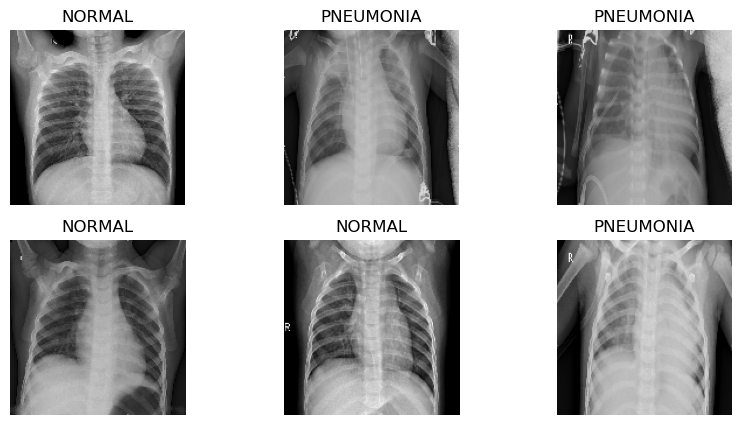

In [18]:
# Visualize some images
plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

### Augmentation and Scaling
- Reduce overfitting by using data augmentation (Generalization)
    - Prevents overfitting (since CNNs can memorize training images).
    - Simulates real-world variations like small rotations or shifts.
    - Helps the model generalize better to unseen images.
- Normalize the pixel values to be between 0 and 1 from 0 to 255 by dividing by 255

In [19]:
# normalize pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)

# apply data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

# prefetch for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Model Architecture

We will use a Convolutional Neural Network (CNN) to classify the images. A Convolutional Neural Network (CNN) is ideal for image classification because it extracts features (like edges, textures, and shapes) using convolutional layers. 

### Model Definition

We will leverage a moderate CNN with the following layers:

- Convolutional Layers (Conv2D)
    - Detects patterns like edges, textures, and shapes.
    - Uses small filters (kernels) (e.g., 3x3) to scan the image.
    - Activation function: ReLU (Rectified Linear Unit) (removes negative values to introduce non-linearity).

- Pooling Layers (MaxPooling2D)
    - Reduces spatial size while keeping important features.
    - Helps prevent overfitting and improves computational efficiency.
    - Common choice: MaxPooling (2x2).

- Dropout Layers
    - Randomly turns off neurons during training.
    - Helps prevent overfitting by forcing the model to generalize.

- Fully Connected Layers (Dense)
    - Takes extracted features and makes predictions.
    - Last layer uses Softmax (for multi-class classification) or Sigmoid (for binary classification).

In [20]:
# Define CNN model
model = keras.Sequential([
    normalization_layer,

    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(1, activation="sigmoid")  # Output layer (binary classification)
])

/Users/rob/micromamba/envs/pneumonia-dl/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Compilation
- Loss Function: Binary Crossentropy
The loss function tells the model how far its predictions are from the correct labels and guides weight updates. We use binary crossentropy for binary classification problems.

- Optimizer: Adam
The optimizer controls how the model updates its weights during training.
We use Adam (Adaptive Moment Estimation) because it automatically adjusts learning rates for each parameter, speeding up convergence.

- Metrics: Accuracy, Precision, Recall, AUC
    - Accuracy is simple and intuitive: it tells us what percentage of predictions are correct.
    - Precision tells us what percentage of positive predictions were correct.
    - Recall tells us what percentage of actual positives were correctly predicted.
    - AUC (Area Under the Curve) is the area under the ROC curve and tells us how well the model is distinguishing between classes.

In [21]:
# Compile the model
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", Precision(), Recall(), AUC()])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Model Training
- The data is already split into training, testing, and validation sets.
- We will train the model on the training set and validate it on the validation set.
- We will use the test set to evaluate the model's performance on unseen data.

In [22]:
# training parameters
EPOCHS = 10

# train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy: 0.7445 - auc: 0.6137 - loss: 0.6131 - precision: 0.7636 - recall: 0.9508 - val_accuracy: 0.7500 - val_auc: 0.8125 - val_loss: 0.5470 - val_precision: 0.8333 - val_recall: 0.6250
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.8449 - auc: 0.9003 - loss: 0.3435 - precision: 0.8798 - recall: 0.9176 - val_accuracy: 0.7500 - val_auc: 0.8438 - val_loss: 0.7991 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - accuracy: 0.8889 - auc: 0.9411 - loss: 0.2740 - precision: 0.9108 - recall: 0.9402 - val_accuracy: 0.6250 - val_auc: 0.9062 - val_loss: 1.0608 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 161ms/step - accuracy: 0.8960 - auc: 0.9446 - loss: 0.2656 - precision: 0.9238 - recall: 0.9351 - val_accuracy: 0.8125 - val_auc: 0.8281 - val_loss: 0.6145 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 5/10
163/163 ━

## Model Evaluation
- We will evaluate the model on the test set using metrics like accuracy, precision, recall, and AUC.
- We will also visualize the confusion matrix to see how well the model is predicting each class.

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8183 - auc: 0.9109 - loss: 0.5576 - precision: 0.8019 - recall: 0.9467
Test accuracy: 0.8108974099159241
Test precision: 0.7931034564971924
Test recall: 0.9435897469520569
Test AUC: 0.9100372195243835


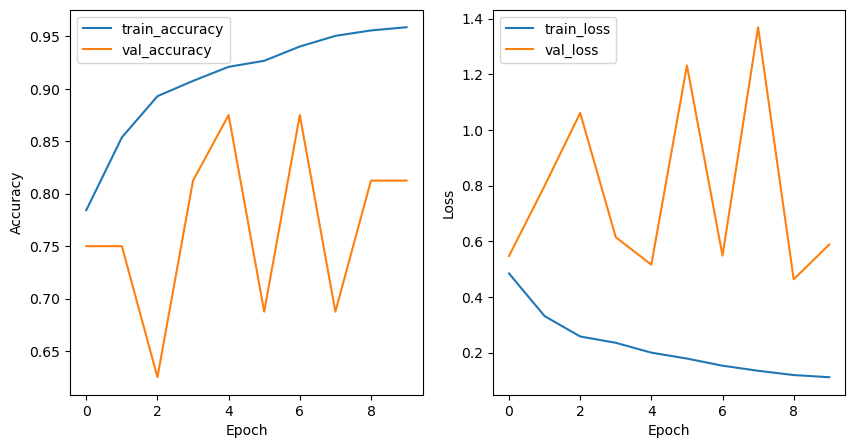

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
              precision    recall  f1-score   support

           0       0.86      0.59      0.70       234
           1       0.79      0.94      0.86       390

    accuracy                           0.81       624
   macro avg       0.83      0.77      0.78       624
weighted avg       0.82      0.81      0.80       624

[[138  96]
 [ 22 368]]


<Figure size 600x600 with 0 Axes>

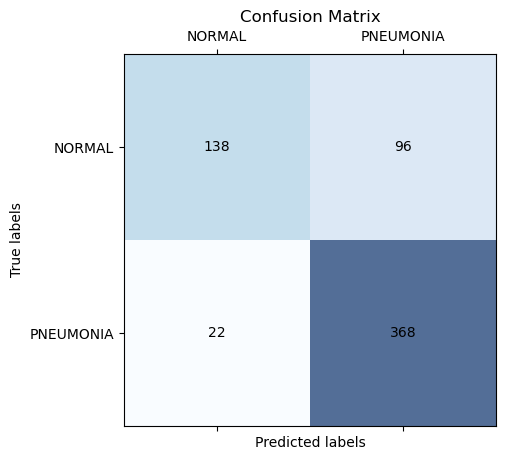

Accuracy: 0.8108974358974359


In [25]:
# evaluate the model
loss, accuracy, precision, recall, auc = model.evaluate(test_dataset)
print("Test accuracy:", accuracy)
print("Test precision:", precision)
print("Test recall:", recall)
print("Test AUC:", auc)

# plot the training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# make predictions
predictions = model.predict(test_dataset)
y_pred = np.round(predictions).flatten()

# get true labels
y_true = []
for _, label in test_dataset:
    y_true.extend(label.numpy())
    
# print classification report
print(classification_report(y_true, y_pred))

# print confusion matrix
print(confusion_matrix(y_true, y_pred))

# visualize confusion matrix
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_true, y_pred)
plt.matshow(cm, cmap="Blues", alpha=0.7)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], va="center", ha="center")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([0, 1], class_names)
plt.yticks([0, 1], class_names)
plt.title("Confusion Matrix")
plt.show()

# print accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# save the model
model.save("models/pneumonia_detection_model.keras")

## Make Predictions
- We will use the model to make predictions on new data.
- We will visualize the predictions to see how well the model is performing.

In [ ]:

# Load an example image
img_path = "data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg"
img = image.load_img(img_path, target_size=IMG_SIZE)

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize

# Make prediction
prediction = model.predict(img_array)
class_idx = (prediction[0] > 0.5).astype("int32")
print(f"Predicted class: {class_names[class_idx[0]]}")
